In [32]:
import pandas as pd

df = pd.read_csv('../Dataset/data.csv')

In [33]:
data = df.sample(10000).reset_index(drop=False)

In [ ]:
data.isnull().sum()

index            0
sequence         0
label            0
mutation_pos     0
ref              0
alt              0
mutation_type    0
chrom            0
genomic_pos      0
context_left     0
context_right    0
dtype: int64

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          10000 non-null  int64 
 1   sequence       10000 non-null  object
 2   label          10000 non-null  int64 
 3   mutation_pos   10000 non-null  int64 
 4   ref            10000 non-null  object
 5   alt            10000 non-null  object
 6   mutation_type  10000 non-null  object
 7   chrom          10000 non-null  object
 8   genomic_pos    10000 non-null  int64 
 9   context_left   10000 non-null  object
 10  context_right  10000 non-null  object
dtypes: int64(4), object(7)
memory usage: 859.5+ KB


In [36]:
data.describe()

,index,label,mutation_pos,genomic_pos
count,1.000000e+04,10000.000000,10000.0,1.000000e+04
mean,9.298995e+05,1.639700,101.0,9.237250e+07
std,5.415940e+05,0.726317,0.0,6.293246e+07
min,3.320000e+02,0.000000,101.0,4.584400e+04
25%,4.571010e+05,1.000000,101.0,4.028171e+07
50%,9.303230e+05,2.000000,101.0,8.685776e+07
75%,1.399947e+06,2.000000,101.0,1.363767e+08
max,1.859214e+06,4.000000,101.0,2.488582e+08


In [37]:
def gc_content(seq):
    seq = seq.upper()
    gc = seq.count('G') + seq.count('C')
    return gc / len(seq)

data['gc_content'] = data['sequence'].apply(gc_content)

In [38]:
def at_content(seq):
    seq = seq.upper()
    return (seq.count('A') + seq.count('T')) / len(seq)

data['at_content'] = data['sequence'].apply(at_content)

In [39]:
def is_cpg_site(row):
    seq = row['sequence'].upper()
    pos = row['mutation_pos']

    if pos < len(seq)-1 and seq[pos] == 'C' and seq[pos+1] == 'G':
        return 1

    if pos > 0 and seq[pos-1] == 'C' and seq[pos] == 'G':
        return 1
    return 0

data['cpg_flag'] = data.apply(is_cpg_site, axis=1)

In [40]:
def cpg_type(row):
    seq = row['sequence'].apply(lambda seq: seq[100])
    return data[seq == "C"][['mutation_type']]

In [41]:
cpg_type(data).value_counts()

mutation_type
C->T             2062
C->G              647
C->A              526
Name: count, dtype: int64

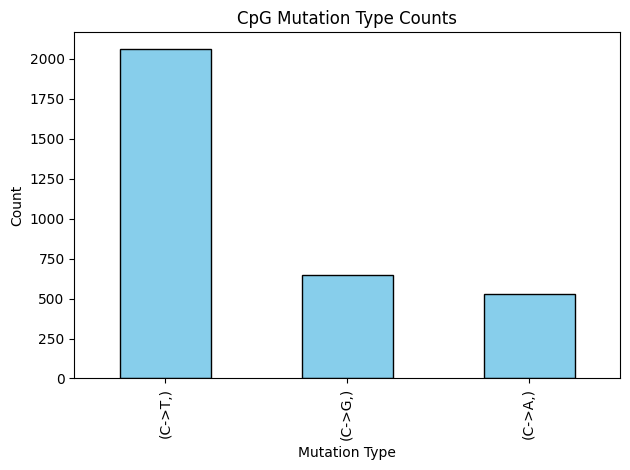

In [42]:
import matplotlib.pyplot as plt

cpg_type(data).value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Mutation Type')
plt.ylabel('Count')
plt.title('CpG Mutation Type Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Hence if the mutation reference base is c next g then it can be likely changed to mutation type C->T because c is methylated.

In [43]:
from collections import Counter
import numpy as np

def sequence_entropy(seq):
    counts = Counter(seq)
    total = len(seq)
    probs = [count / total for count in counts.values()]
    return -sum(p * np.log2(p) for p in probs)

data['sequence_entropy'] = data['sequence'].apply(sequence_entropy)

In [44]:
def is_transition(ref, alt):
    transitions = {('A','G'), ('G','A'), ('C','T'), ('T','C')}
    return 1 if (ref, alt) in transitions else 0

In [45]:
data['is_transition'] = data.apply(lambda row: is_transition(row['ref'], row['alt']), axis=1)

In [46]:
chrom_lengths = {
    'chr1': 248956422,
    'chr2': 242193529,
    'chr3': 198295559,
    'chr4': 190214555,
    'chr5': 181538259,
    'chr6': 170805979,
    'chr7': 159345973,
    'chr8': 145138636,
    'chr9': 138394717,
    'chr10': 133797422,
    'chr11': 135086622,
    'chr12': 133275309,
    'chr13': 114364328,
    'chr14': 107043718,
    'chr15': 101991189,
    'chr16': 90338345,
    'chr17': 83257441,
    'chr18': 80373285,
    'chr19': 58617616,
    'chr20': 64444167,
    'chr21': 46709983,
    'chr22': 50818468,
}

def normalized_genomic_pos(row):
    chrom = row['chrom']
    chrom_length = chrom_lengths.get(chrom, 1) 
    return row['genomic_pos'] / chrom_length

In [47]:
data['genomic_pos_norm'] = data.apply(normalized_genomic_pos, axis=1)

In [48]:
def get_codon(seq, k=3):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

In [49]:
def pair_count(seq, k=3):
    kmers = get_codon(seq, k)
    kmer_counts = Counter(kmers)
    
    return [kmer_counts[kmer] for kmer in kmers]

In [50]:
data['pair_count'] = data['sequence'].apply(pair_count)

In [51]:
vocab = {}

for seq in data['sequence']:
    for codons in get_codon(seq.lower()):
        if codons not in vocab:
            vocab[codons] = len(vocab)
        else:
            continue

def get_tensor(text):
    return [vocab[codons.lower()] for codons in get_codon(text)]

In [52]:
data.head()

,index,sequence,label,mutation_pos,ref,alt,mutation_type,chrom,genomic_pos,context_left,context_right,gc_content,at_content,cpg_flag,sequence_entropy,is_transition,genomic_pos_norm,pair_count
0,167680,GAATATGGCAGTGCCTGAGTCGCTATCCCAGCCATGAATCTGCAAA...,2,101,G,A,G->A,chr1,158331023,GAATATGGCAGTGCCTGAGTCGCTATCCCAGCCATGAATCTGCAAA...,AGGTCTGGATAACATGAAAGGAGGTCGGCCCCTGGAAGGCTGTGAA...,0.487562,0.512438,0,1.952545,1,0.635979,"[9, 4, 3, 3, 4, 6, 3, 4, 5, 4, 5, 3, 6, 4, 6, ..."
1,298865,GACAGTTCTAGACTTAAGGAAGCAGGAGAACAAGCAGTTGAGGTGT...,1,101,G,A,G->A,chr2,27312258,GACAGTTCTAGACTTAAGGAAGCAGGAGAACAAGCAGTTGAGGTGT...,AGAAGGAACAAATTAACACTTGCGCCTCCAAGCAGCTCCCACTTCC...,0.467662,0.532338,0,1.978487,1,0.112770,"[4, 10, 9, 5, 4, 4, 2, 1, 3, 7, 4, 4, 5, 3, 4,..."
2,925595,GGCCAGAACGCCTGGCTGTCATACCTCCTGCTTAAGGCCAGCGAGC...,2,101,T,C,T->C,chr5,141384794,GGCCAGAACGCCTGGCTGTCATACCTCCTGCTTAAGGCCAGCGAGC...,GCTGGACAGAGATGCCCTCAAGCAGAGCCTCGTGGTGGCCGTCCAG...,0.656716,0.343284,0,1.926190,1,0.778815,"[10, 10, 6, 8, 4, 1, 1, 4, 2, 10, 8, 8, 7, 10,..."
3,108888,ATTAGGACATAGCAAAGCTTACTCAATGTCTACTTTTTTTTTTTTT...,2,101,G,T,G->T,chr1,74436123,ATTAGGACATAGCAAAGCTTACTCAATGTCTACTTTTTTTTTTTTT...,ATTTTGGAGGTGAGATACCCCAAAATGGCATCCTTTTTTTCTTTGT...,0.368159,0.631841,0,1.927714,0,0.298993,"[4, 3, 3, 3, 3, 1, 5, 4, 5, 3, 3, 4, 5, 4, 1, ..."
4,21453,CACTTTACTAATTTGTTCATAGGTGAGCTACATGGAAATTTACTGT...,2,101,G,C,G->C,chr1,10267458,CACTTTACTAATTTGTTCATAGGTGAGCTACATGGAAATTTACTGT...,AACACCCACTTCTTGGACCCTATGTGGAGGATCTGTCCAAGTTGGC...,0.437811,0.562189,0,1.987057,0,0.041242,"[4, 5, 4, 5, 3, 6, 5, 4, 2, 4, 5, 5, 6, 5, 3, ..."
